In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [21]:
engine = create_engine("sqlite:///Resources_hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [23]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
Measure = Base.classes.measurement
Station = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [26]:
#get columns
inspector = inspect(engine)
measure_columns = inspector.get_columns('measurement')

for m in measure_columns:
    print(m['name'])

id
station
date
prcp
tobs


In [27]:
station_columns = inspector.get_columns('station')

for s in station_columns:
    print(s['name'])

id
station
name
latitude
longitude
elevation


# Exploratory Climate Analysis

Text(0.5, 1.0, 'PRCP')

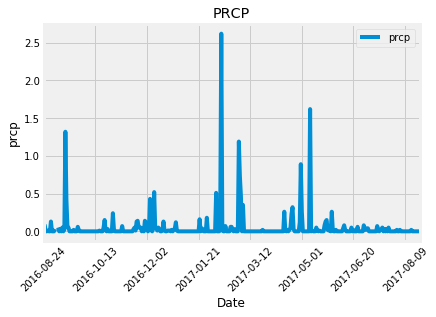

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
last = session.query(Measure.date).order_by(Measure.date.desc()).first()
year_ago = dt.datetime.strptime('2017-08-23', '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
data = session.query(Measure.date, Measure.prcp).filter(Measure.date > year_ago).group_by(Measure.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measure_df = pd.DataFrame(data, columns=['date', 'prcp'])
measure_df = measure_df.set_index(['date'])
# Sort the dataframe by date
measure_df.sort_values(by='date', ascending= False)
# Use Pandas Plotting with Matplotlib to plot the data
measure_df.plot()
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('prcp')
plt.title('PRCP')

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measure_df.describe()

,prcp
count,363.000000
mean,0.048843
std,0.205197
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


In [30]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Measure.station).distinct(Measure.station).count()
num_stations

9

In [31]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count = session.query(Measure.station, func.count(Measure.station)).group_by(Measure.station).\
        order_by(func.count(Measure.station).desc()).all()
count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measure.station, func.min(Measure.tobs), func.max(Measure.tobs), func.avg(Measure.tobs)). \
filter(Measure.station == count[0][0]).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

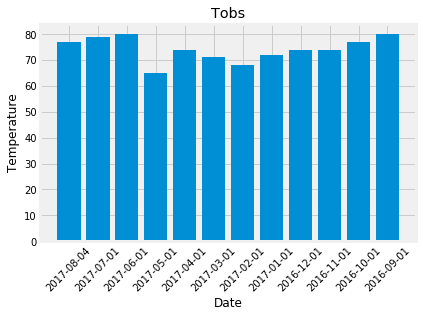

In [53]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

max_tobs = session.query(Measure.date, Measure.tobs).\
            filter(Measure.station == count[0][0]).\
            filter(Measure.date >= year_ago).\
            group_by(func.strftime('%Y-%m', Measure.date)).\
            order_by(Measure.date.desc()).limit(12).all()

x_values = session.query(Measure.date).\
            filter(Measure.station == count[0][0]).\
            filter(Measure.date >= year_ago).\
            group_by(func.strftime('%Y-%m', Measure.date)).\
            order_by(Measure.date.desc()).limit(12).all()

y_values = session.query(func.count(Measure.date)).\
            filter(Measure.station == count[0][0]).\
            filter(Measure.station >= year_ago).\
            group_by(func.strftime('%Y-%m', Measure.date)).\
            order_by(Measure.date.desc()).limit(12).all()

tobs_df = pd.DataFrame(max_tobs, columns=['date', 'tobs'])
plt.bar(tobs_df['date'], tobs_df['tobs'])

plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Tobs')

plt.show()

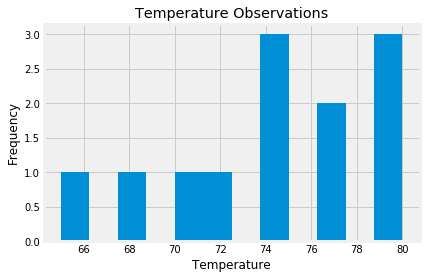

In [52]:
bins = 12
plt.hist(tobs_df['tobs'], bins)
plt.title("Temperature Observations")
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    
    return session.query(func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)).\
        filter(Measure.date >= start_date).filter(Measure.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
previous_start = dt.datetime.strptime('2012-02-28', '%Y-%m-%d') - dt.timedelta(days=365)
previous_end = dt.datetime.strptime('2012-03-05', '%Y-%m-%d') - dt.timedelta(days=365)
previous_year_data = calc_temps(previous_start, previous_end)
print(previous_year_data)

[(61.0, 70.17021276595744, 75.0)]


Text(0, 0.5, 'Average Temperature (F)')

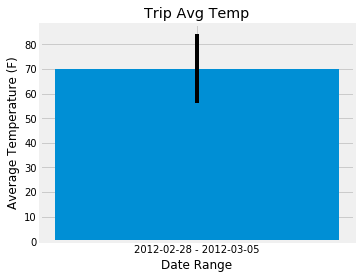

In [36]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#x/y values 
y_val = previous_year_data[0][1]
x =  '2012-02-28 - 2012-03-05'

#yerr
error = [previous_year_data[0][2] - previous_year_data[0][0]]

fig3 = plt.figure(figsize=(5,4))
plt.bar(x, y_val, yerr=error, width=0.25)

#labels
plt.title('Trip Avg Temp')
plt.xlabel('Date Range')
plt.ylabel('Average Temperature (F)')




In [37]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rainfall = session.query(Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measure.prcp)).\
                filter(Station.station == Measure.station).\
                filter(Measure.date >= previous_start).\
                filter(Measure.date <= previous_end).\
                group_by(Measure.station).\
                order_by(func.sum(Measure.prcp).desc()).all()

total_rainfall


[('WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 3.74),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.6),
 ('KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.5999999999999996),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.44),
 ('UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 2.33),
 ('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.69),
 ('WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.41),
 ('HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.63),
 ('PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [38]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measure.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [39]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
trip_dates = []
# Set the start and end date of the trip
start_date = dt.datetime.strptime('2012-02-28', '%Y-%m-%d')
end_date = dt.datetime.strptime('2012-03-05', '%Y-%m-%d')
# Use the start and end date to create a range of dates
date_range = (start_date + dt.timedelta(days=x) for x in range(0, (end_date-start_date).days))
# Stip off the year and save a list of %m-%d strings
md_range= (md_string.strftime('%m-%d') for md_string in date_range)
# Loop through the list of %m-%d strings and calculate the normals for each date
for md in md_range:
    trip_dates.append(md)
    normals.append(daily_normals(md)[0])
    
normals
    


[(65.0, 70.65517241379311, 80.0),
 (67.0, 71.73333333333333, 79.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0)]

In [40]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, columns=['Tmin', 'Tavg', 'Tmax'])  
trip_df['trip_dates'] = trip_dates
trip_df = trip_df.set_index(['trip_dates'])
trip_df


,Tmin,Tavg,Tmax
trip_dates,,,
02-28,65.0,70.655172,80.0
02-29,67.0,71.733333,79.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0


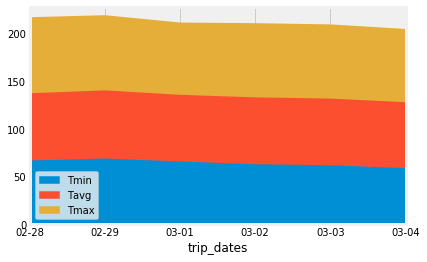

In [41]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area()